# Multi Step Forecasting

1) Seq2Seq models
2) Encoder Decoder models
3) Attention based models
4) Dual input model framework

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import os
import torch
import torch.nn as nn

In [2]:
cpu_temp = pd.read_csv("../data/cpu-temp.csv", header=None, names=["time", "cpu_temp"])
fan_speed = pd.read_csv("../data/fan-speed.csv", header=None, names=["time", "fan_speed"])
inlet_temp = pd.read_csv("../data/inlet-temp.csv", header=None, names=["time", "inlet_temp"])
it_power = pd.read_csv("../data/it-power.csv", header=None, names=["time", "it_power"])

In [3]:
def process_dataframe(df, time_col, value_col):
    df[time_col] = df[time_col].astype(int)

    min_time = df[time_col].min()
    max_time = df[time_col].max()
    full_index = pd.DataFrame({time_col: np.arange(min_time, max_time + 1)})

    df_full = pd.merge(full_index, df, on=time_col, how='left')
    df_full[value_col] = df_full[value_col].interpolate(method="polynomial", order=2)

    return df_full

cpu_temp_new = process_dataframe(cpu_temp, "time", "cpu_temp")
fan_speed_new = process_dataframe(fan_speed, "time", "fan_speed")
inlet_temp_new = process_dataframe(inlet_temp, "time", "inlet_temp")
it_power_new = process_dataframe(it_power, "time", "it_power")

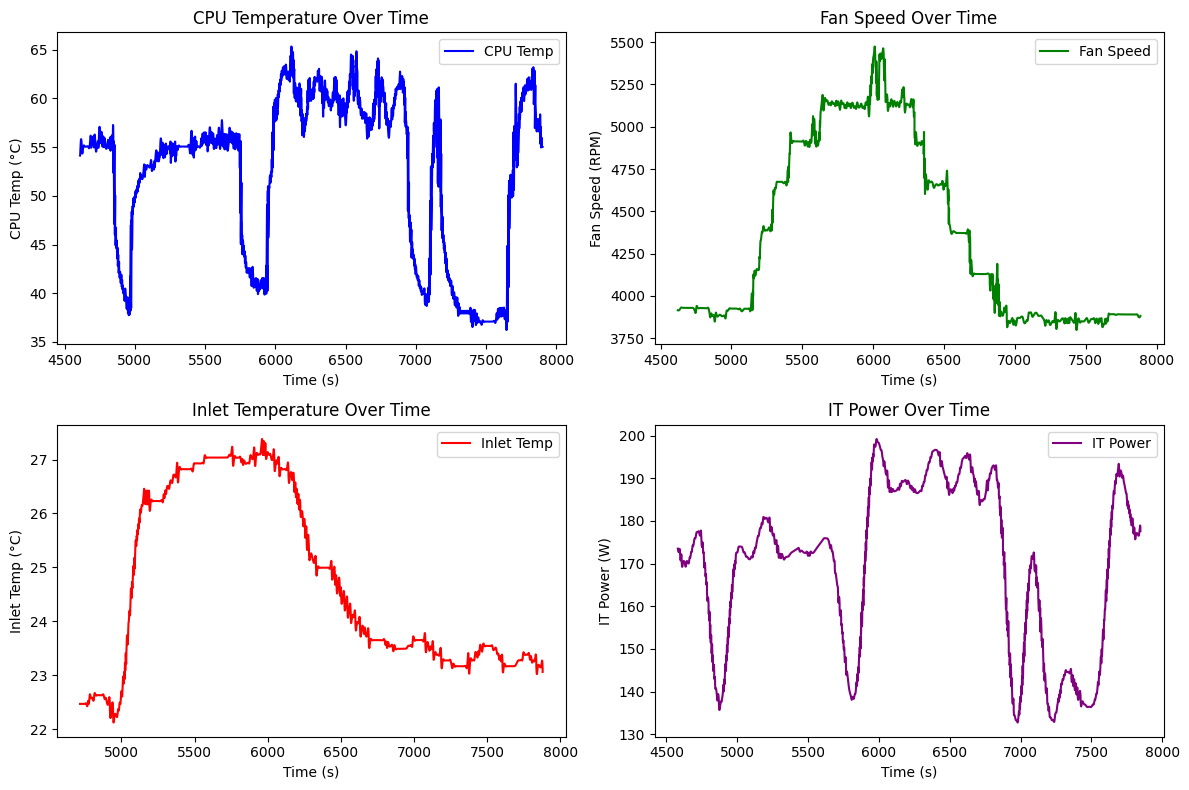

In [4]:
def plot_time_series_subplots(cpu_temp_df, fan_speed_df, inlet_temp_df, it_power_df, time_col):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # First subplot - CPU Temperature
    axs[0, 0].plot(cpu_temp_df[time_col], cpu_temp_df['cpu_temp'], color='blue', label='CPU Temp')
    axs[0, 0].set_title('CPU Temperature Over Time')
    axs[0, 0].set_xlabel('Time (s)')
    axs[0, 0].set_ylabel('CPU Temp (°C)')
    axs[0, 0].legend()

    # Second subplot - Fan Speed
    axs[0, 1].plot(fan_speed_df[time_col], fan_speed_df['fan_speed'], color='green', label='Fan Speed')
    axs[0, 1].set_title('Fan Speed Over Time')
    axs[0, 1].set_xlabel('Time (s)')
    axs[0, 1].set_ylabel('Fan Speed (RPM)')
    axs[0, 1].legend()

    # Third subplot - Inlet Temperature
    axs[1, 0].plot(inlet_temp_df[time_col], inlet_temp_df['inlet_temp'], color='red', label='Inlet Temp')
    axs[1, 0].set_title('Inlet Temperature Over Time')
    axs[1, 0].set_xlabel('Time (s)')
    axs[1, 0].set_ylabel('Inlet Temp (°C)')
    axs[1, 0].legend()

    # Fourth subplot - IT Power
    axs[1, 1].plot(it_power_df[time_col], it_power_df['it_power'], color='purple', label='IT Power')
    axs[1, 1].set_title('IT Power Over Time')
    axs[1, 1].set_xlabel('Time (s)')
    axs[1, 1].set_ylabel('IT Power (W)')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


plot_time_series_subplots(cpu_temp_new, fan_speed_new, inlet_temp_new, it_power_new, time_col="time")

In [5]:
max_start = max(inlet_temp_new['time'].min(), cpu_temp_new['time'].min(), it_power_new['time'].min(), fan_speed_new['time'].min())
min_end = min(inlet_temp_new['time'].max(), cpu_temp_new['time'].max(), it_power_new['time'].max(), fan_speed_new['time'].max())

cpu_temp_filtered = cpu_temp_new[(cpu_temp_new['time'] >= max_start) & (cpu_temp_new['time'] <= min_end)]
inlet_temp_filtered = inlet_temp_new[(inlet_temp_new['time'] >= max_start) & (inlet_temp_new['time'] <= min_end)]
it_power_filtered = it_power_new[(it_power_new['time'] >= max_start) & (it_power_new['time'] <= min_end)]
fan_speed_filtered = fan_speed_new[(fan_speed_new['time'] >= max_start) & (fan_speed_new['time'] <= min_end)]

combined_df = pd.merge(cpu_temp_filtered, inlet_temp_filtered, on='time')
combined_df = pd.merge(combined_df, it_power_filtered, on='time')
combined_df = pd.merge(combined_df, fan_speed_filtered, on='time')

combined_df.head()

,time,cpu_temp,inlet_temp,it_power,fan_speed
0,4718,55.766525,22.468243,177.345436,3929.161963
1,4719,55.608490,22.468213,177.350546,3929.225715
2,4720,55.446706,22.468188,177.362315,3929.311931
3,4721,55.238044,22.468170,177.380743,3929.420613
4,4721,54.960208,22.468170,177.380743,3929.420613


In [6]:
df = combined_df.copy()
print(f"Shape of Final Dataframe = {df.shape}")

Shape of Final Dataframe = (4255, 5)


In [7]:
scalers = {
    'cpu_temp': MinMaxScaler(),
    'inlet_temp': MinMaxScaler(),
    'it_power': MinMaxScaler(),
    'fan_speed': MinMaxScaler()
}

df_scaled = pd.DataFrame(index=df.index)

for col, scaler in scalers.items():
    df_scaled[col] = scaler.fit_transform(df[[col]]).ravel()

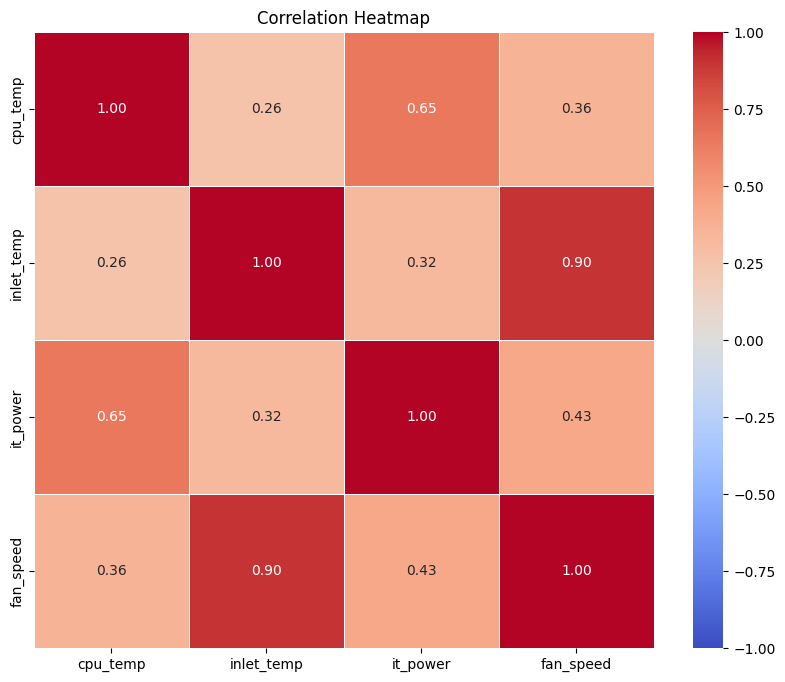

In [8]:
cols = ["cpu_temp", "inlet_temp", "it_power", "fan_speed"]

corr = df[cols].corr()

plt.figure(figsize=(10, 8)) 
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [9]:
df_scaled.head()

,cpu_temp,inlet_temp,it_power,fan_speed
0,0.671717,0.065816,0.671238,0.077869
1,0.666286,0.065810,0.671315,0.077907
2,0.660725,0.065806,0.671492,0.077959
3,0.653554,0.065802,0.671769,0.078024
4,0.644006,0.065802,0.671769,0.078024


In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

In [11]:
class MultiStepForecaster:
    def __init__(self, data, window_size, pred_horizon, target_col, hidden_size=64, num_layers=2, batch_size=32, learning_rate=0.001, num_epochs=100, method="recursive"):
        self.data = data
        self.window_size = window_size
        self.pred_horizon = pred_horizon
        self.target_col = target_col

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

        self.model = None
        self.criterion = None
        self.optimizer = None

        self.method = method

    def prepare_recursive_data(self):
        X, y = [], []

        for i in range(len(self.data) - self.window_size - 1):
            X.append(self.data[i:i + self.window_size])
            y.append(self.data[i + self.window_size, self.target_col])

        X = np.array(X)
        y = np.array(y)

        return X, y

    def prepare_multi_output_data(self):
        X, y = [], []

        for i in range(len(self.data) - self.window_size - self.pred_horizon):
            X.append(self.data[i:i + self.window_size])
            y.append(self.data[i + self.window_size:i + self.window_size + self.pred_horizon, self.target_col])

        X = np.array(X)
        y = np.array(y)

        return X, y

    def prepare_data(self):

        if self.method == "recursive":
            X, y = self.prepare_recursive_data()
        elif self.method == "multi-output":
            X, y = self.prepare_multi_output_data()

        return X, y
    
    def train_test_split(self, X, y, test_size=0.2):
        split_idx = int(len(X) * (1 - test_size))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        return X_train, X_test, y_train, y_test
    
    def build_model(self):

        input_size = self.data.shape[1] 
        output_size = 1 if self.method == "recursive" else self.pred_horizon

        self.model = LSTMModel(input_size, self.hidden_size, self.num_layers, output_size)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def train_model(self, X_train, y_train):
        self.model.train()

        for epoch in range(self.num_epochs):
            inputs = torch.tensor(X_train, dtype=torch.float32)
            targets = torch.tensor(y_train, dtype=torch.float32)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)

            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()

            if (epoch+1) % 10 == 0:
                print(f'Epoch {epoch+1} Loss: {loss.item()}')

        if self.method == "recursive":  
            torch.save(self.model.state_dict(), "../models/recursive_model.pth")
        elif self.method == "multi-output":
            torch.save(self.model.state_dict(), "../models/multi_output_model.pth")

    def recursive_forecast(self, X_test):
        self.model.eval()
        recursive_predictions = []

        with torch.no_grad():
            for i in range(len(X_test)):
                current_input = X_test[i].astype(np.float32)
                sample_predictions = []  

                for _ in range(self.pred_horizon):
                    current_input_tensor = torch.tensor(current_input, dtype=torch.float32).unsqueeze(0)
                    prediction = self.model(current_input_tensor).view(-1).item()
                    
                    sample_predictions.append(prediction)  
                    
                    current_input = np.roll(current_input, -1, axis=0)
                    current_input[-1, self.target_col] = prediction

                recursive_predictions.append(sample_predictions)  

        return np.array(recursive_predictions)

    def multi_output_forecast(self, X_test):
        self.model.eval()
        
        with torch.no_grad():
            inputs = torch.tensor(X_test, dtype=torch.float32)
            y_pred = self.model(inputs).numpy()

        return y_pred

    def evaluate(self, X_test, y_test):
        if self.method == "recursive":
            preds = self.recursive_forecast(X_test)
        elif self.method == "multi-output":
            preds = self.multi_output_forecast(X_test)

        y_test = y_test if len(y_test.shape) == len(preds.shape) else y_test.reshape(preds.shape)
        
        y_test_unscaled = scalers["cpu_temp"].inverse_transform(y_test)
        preds_unscaled = scalers["cpu_temp"].inverse_transform(preds)

        mse = np.mean((preds_unscaled - y_test_unscaled) ** 2)
        r2 = r2_score(y_test_unscaled, preds_unscaled)

        print(f"Mean Squared Error: {mse:.4f}")
        print(f"R² Score: {r2:.4f}")

        return mse, r2, preds, y_test
       

In [12]:
class Pipeline:
    def __init__(self, data, window_size, pred_horizon, target_col, hidden_size=64, num_layers=2, batch_size=32, learning_rate=0.001, num_epochs=100):
        self.data = data
        self.window_size = window_size
        self.pred_horizon = pred_horizon
        self.target_col = target_col
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

        self.recursive_forecaster = MultiStepForecaster(
            data=self.data,
            window_size=self.window_size,
            pred_horizon=self.pred_horizon,
            target_col=self.target_col,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_size=self.batch_size,
            learning_rate=self.learning_rate,
            num_epochs=self.num_epochs,
            method="recursive"
        )

        self.multi_output_forecaster = MultiStepForecaster(
            data=self.data,
            window_size=self.window_size,
            pred_horizon=self.pred_horizon,
            target_col=self.target_col,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_size=self.batch_size,
            learning_rate=self.learning_rate,
            num_epochs=self.num_epochs,
            method="multi-output"
        )

    def execute_recursive(self):
        # Initialize forecaster with recursive method
        forecaster = self.recursive_forecaster

        # Prepare data
        X, y = forecaster.prepare_data()
        X_train, X_test, y_train, y_test = forecaster.train_test_split(X, y)

        # Build, train, and evaluate the model
        forecaster.build_model()
        forecaster.train_model(X_train, y_train)

        X, y = self.multi_output_forecaster.prepare_data()
        X_train, X_test, y_train, y_test = self.multi_output_forecaster.train_test_split(X, y)
        # print(f"Test size: {y_test.shape}")
        mse, r2, preds, y_test = forecaster.evaluate(X_test, y_test)

        return mse, r2, preds, y_test
    
    def execute_multi_output(self):
        # Initialize forecaster with multi-output method
        forecaster = self.multi_output_forecaster

        # Prepare data
        X, y = forecaster.prepare_data()
        X_train, X_test, y_train, y_test = forecaster.train_test_split(X, y)
        # print(f"Test size: {y_test.shape}")

        # Build, train, and evaluate the model
        forecaster.build_model()
        forecaster.train_model(X_train, y_train)
        mse, r2, preds, y_test = forecaster.evaluate(X_test, y_test)

        return mse, r2, preds, y_test


In [18]:
data = df_scaled.to_numpy()
window_size = 30
pred_horizon = 15
target_col = 0

hidden_size = 64
num_layers = 2
batch_size = 64
learning_rate = 0.001
num_epochs = 100

modeling_pipeline = Pipeline(
    data=data,
    window_size=window_size,
    pred_horizon=pred_horizon,
    target_col=target_col,
    hidden_size=hidden_size,
    num_layers=num_layers,
    batch_size=batch_size,
    learning_rate=learning_rate,
    num_epochs=num_epochs
)

In [26]:
print("Executing Recursive Forecasting:")
_, _, y_pred, y_test = modeling_pipeline.execute_recursive()

Executing Recursive Forecasting:


d:\DDP\data-center-modeling\dc-venv\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([3379])) that is different to the input size (torch.Size([3379, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10 Loss: 0.16767609119415283
Epoch 20 Loss: 0.06822457909584045
Epoch 30 Loss: 0.06695646792650223
Epoch 40 Loss: 0.06063558906316757
Epoch 50 Loss: 0.05782453343272209
Epoch 60 Loss: 0.05690094083547592
Epoch 70 Loss: 0.05654830485582352
Epoch 80 Loss: 0.05631198734045029
Epoch 90 Loss: 0.056150078773498535
Epoch 100 Loss: 0.05605132132768631
Mean Squared Error: 161.4285
R² Score: -1.0448


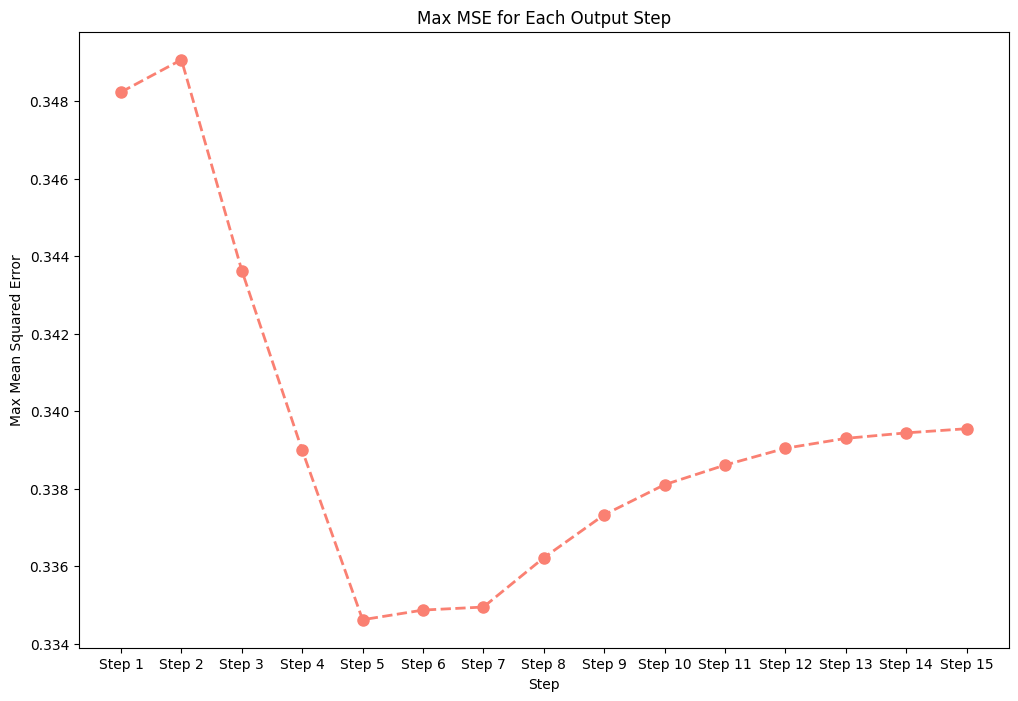

In [20]:
max_mse_per_step = [np.max([mean_squared_error(y_test[j, :i+1], y_pred[j, :i+1]) for j in range(y_test.shape[0])]) for i in range(pred_horizon)]

plt.figure(figsize=(12, 8))
plt.plot(range(1, pred_horizon + 1), max_mse_per_step, color='salmon', marker='o', linestyle='dashed', linewidth=2, markersize=8)
plt.xlabel('Step')
plt.ylabel('Max Mean Squared Error')
plt.title('Max MSE for Each Output Step')
plt.xticks(range(1, pred_horizon + 1), labels=[f'Step {i}' for i in range(1, pred_horizon + 1)])
plt.show()

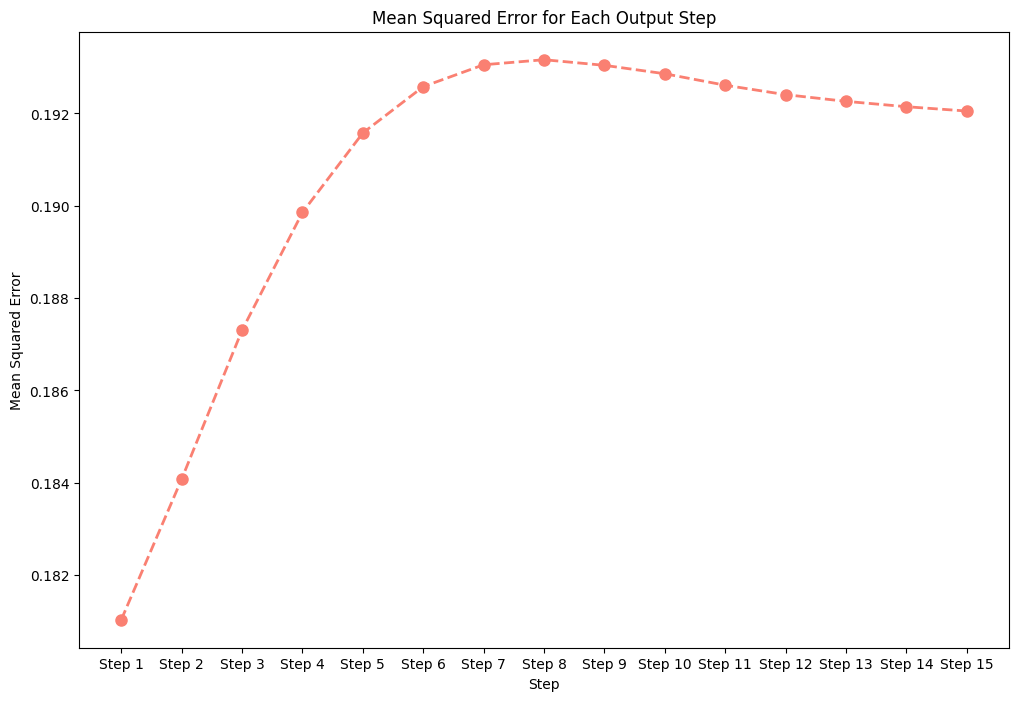

In [27]:
mse_scores = [mean_squared_error(y_test[:, i], y_pred[:, i]) for i in range(pred_horizon)]

plt.figure(figsize=(12, 8))
plt.plot(range(1, pred_horizon+1), mse_scores, color='salmon', marker='o', linestyle='dashed', linewidth=2, markersize=8)
plt.xlabel('Step')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error for Each Output Step')
plt.xticks(range(1, pred_horizon+1), labels=[f'Step {i}' for i in range(1, pred_horizon+1)])
plt.show()

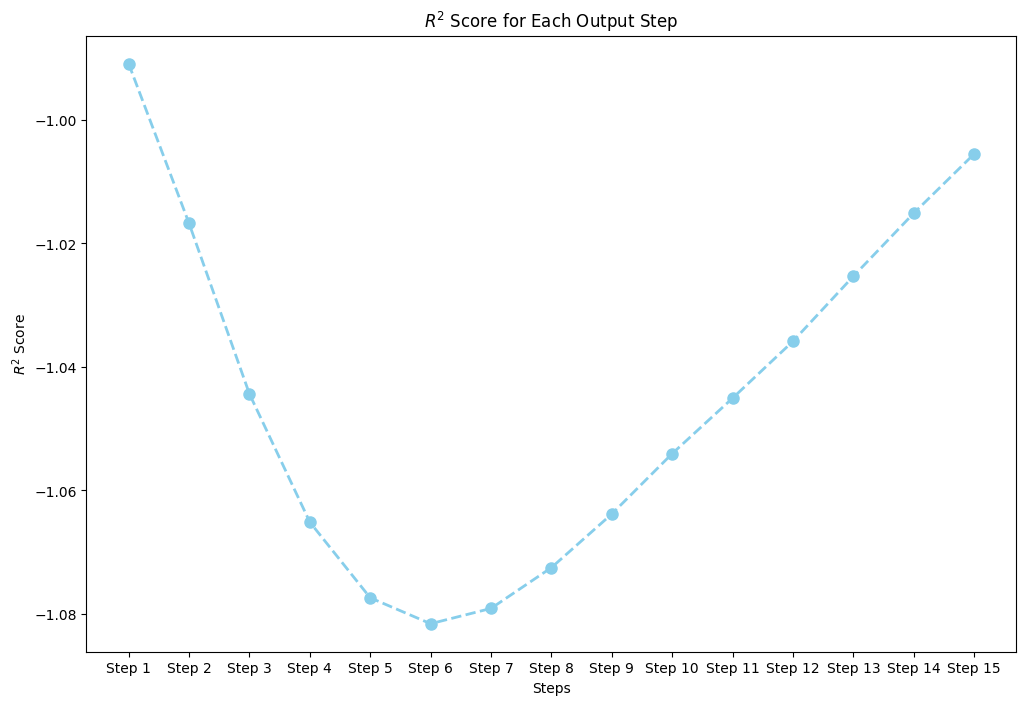

In [28]:
r2_scores = [r2_score(y_test[:, i], y_pred[:, i]) for i in range(pred_horizon)]

plt.figure(figsize=(12, 8))
plt.plot(range(1, pred_horizon+1), r2_scores, color='skyblue', marker='o', linestyle='dashed', linewidth=2, markersize=8)
plt.xlabel('Steps')
plt.ylabel('$R^2$ Score')
plt.title('$R^2$ Score for Each Output Step')
plt.xticks(range(1, pred_horizon+1), labels=[f'Step {i}' for i in range(1, pred_horizon+1)])
plt.show()

R² Score for Horizon 1: -0.9909
R² Score for Horizon 2: -1.0168
R² Score for Horizon 3: -1.0444
R² Score for Horizon 4: -1.0651
R² Score for Horizon 5: -1.0774
R² Score for Horizon 6: -1.0816
R² Score for Horizon 7: -1.0791
R² Score for Horizon 8: -1.0725
R² Score for Horizon 9: -1.0638
R² Score for Horizon 10: -1.0541
R² Score for Horizon 11: -1.0451
R² Score for Horizon 12: -1.0359
R² Score for Horizon 13: -1.0253
R² Score for Horizon 14: -1.0151
R² Score for Horizon 15: -1.0055
MSE for Horizon 1: 0.1810
MSE for Horizon 2: 0.1841
MSE for Horizon 3: 0.1873
MSE for Horizon 4: 0.1899
MSE for Horizon 5: 0.1916
MSE for Horizon 6: 0.1926
MSE for Horizon 7: 0.1931
MSE for Horizon 8: 0.1932
MSE for Horizon 9: 0.1930
MSE for Horizon 10: 0.1929
MSE for Horizon 11: 0.1926
MSE for Horizon 12: 0.1924
MSE for Horizon 13: 0.1923
MSE for Horizon 14: 0.1921
MSE for Horizon 15: 0.1921


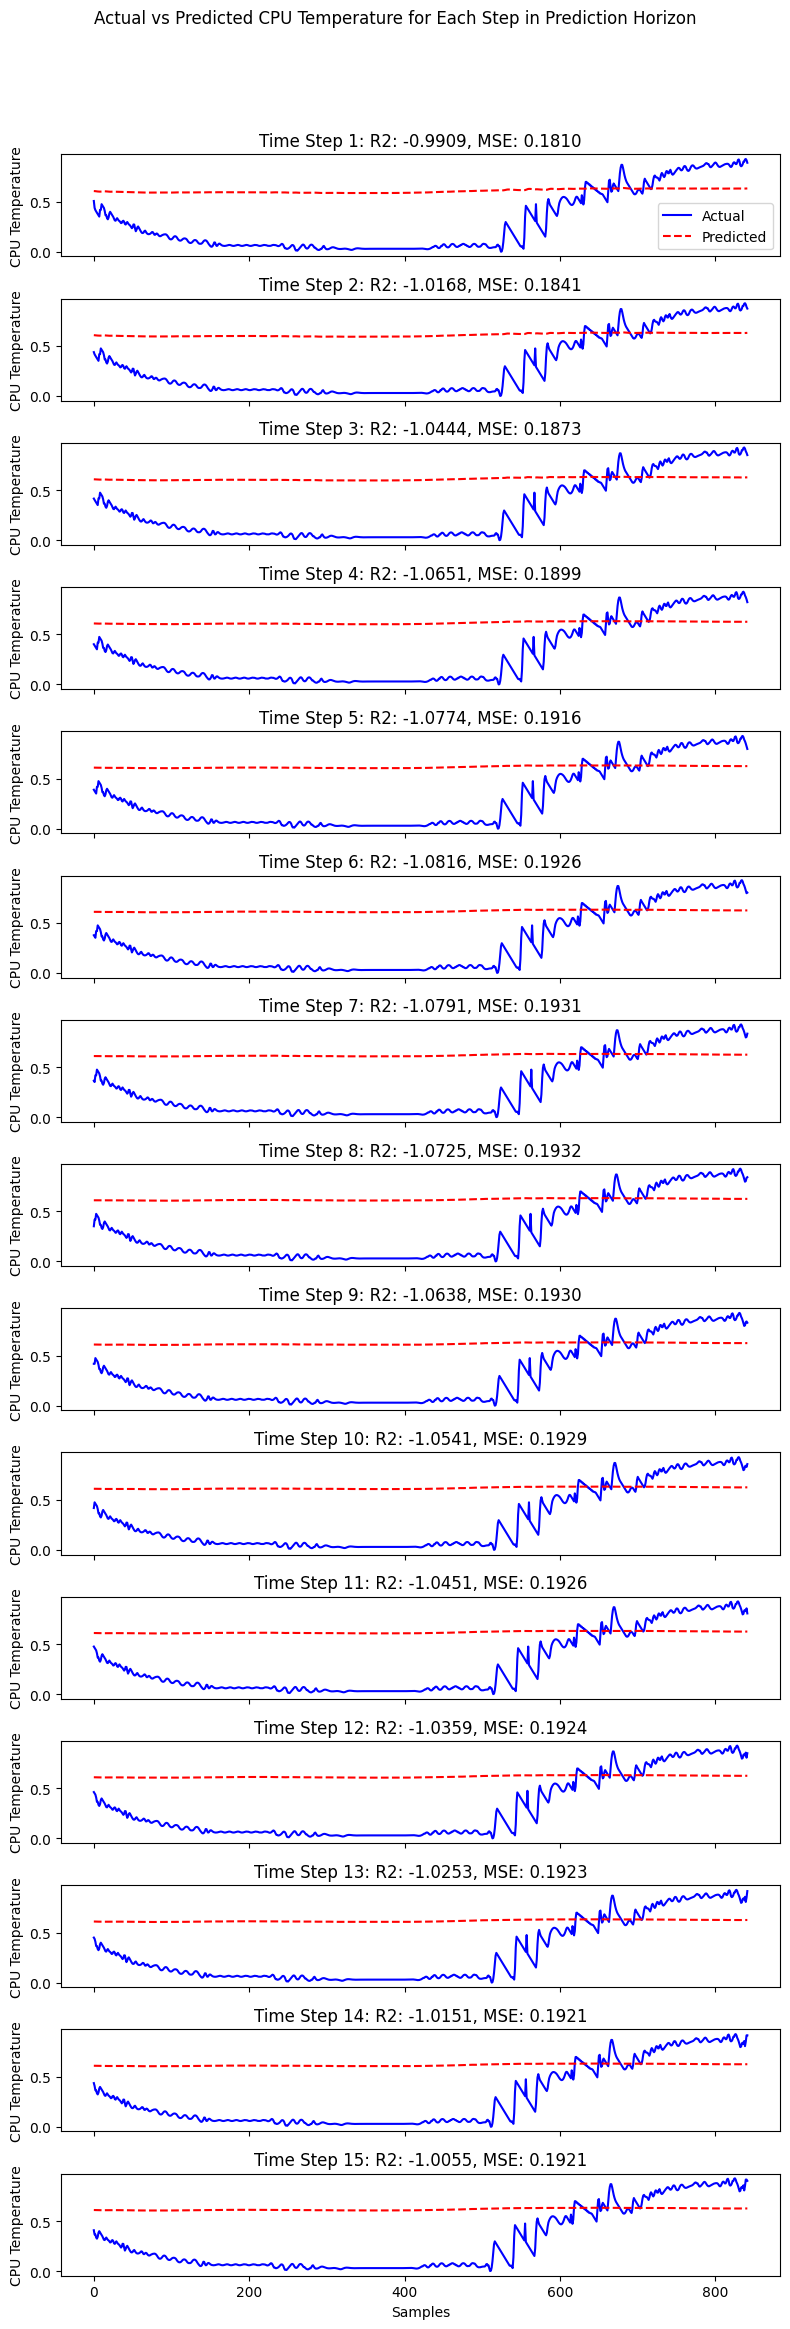

In [29]:
mse_scores = mse_scores
r2_scores = r2_scores

for step in range(y_pred.shape[1]):
    r2 = r2_score(y_test[:, step], y_pred[:, step])
    r2_scores.append(r2)
    print(f"R² Score for Horizon {step + 1}: {r2:.4f}")

for step in range(y_pred.shape[1]):
    mse = mean_squared_error(y_test[:, step], y_pred[:, step])
    mse_scores.append(mse)
    print(f"MSE for Horizon {step + 1}: {mse:.4f}")

output_horizon = y_pred.shape[1]
fig, axes = plt.subplots(output_horizon, 1, figsize=(8, 25), sharex=True)

for step in range(output_horizon):
    axes[step].plot(y_test[:, step], label='Actual', color='blue')
    axes[step].plot(y_pred[:, step], label='Predicted', color='red', linestyle='dashed')
    axes[step].set_title(f'Time Step {step + 1}: R2: {r2_scores[step]:.4f}, MSE: {mse_scores[step]:.4f}')
    axes[step].set_ylabel("CPU Temperature")
    if step == 0:
        axes[step].legend()

plt.xlabel("Samples")
plt.suptitle("Actual vs Predicted CPU Temperature for Each Step in Prediction Horizon")
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

In [22]:
print("\nExecuting Multi-Output Forecasting:")
_, _, y_pred, y_test = modeling_pipeline.execute_multi_output()


Executing Multi-Output Forecasting:
Epoch 10 Loss: 0.2528083026409149
Epoch 20 Loss: 0.08515673130750656
Epoch 30 Loss: 0.051732659339904785
Epoch 40 Loss: 0.04303278774023056
Epoch 50 Loss: 0.033506136387586594
Epoch 60 Loss: 0.020889809355139732
Epoch 70 Loss: 0.009461378678679466
Epoch 80 Loss: 0.005518556106835604
Epoch 90 Loss: 0.0045734914019703865
Epoch 100 Loss: 0.004032935481518507
Mean Squared Error: 6.6858
R² Score: 0.9154


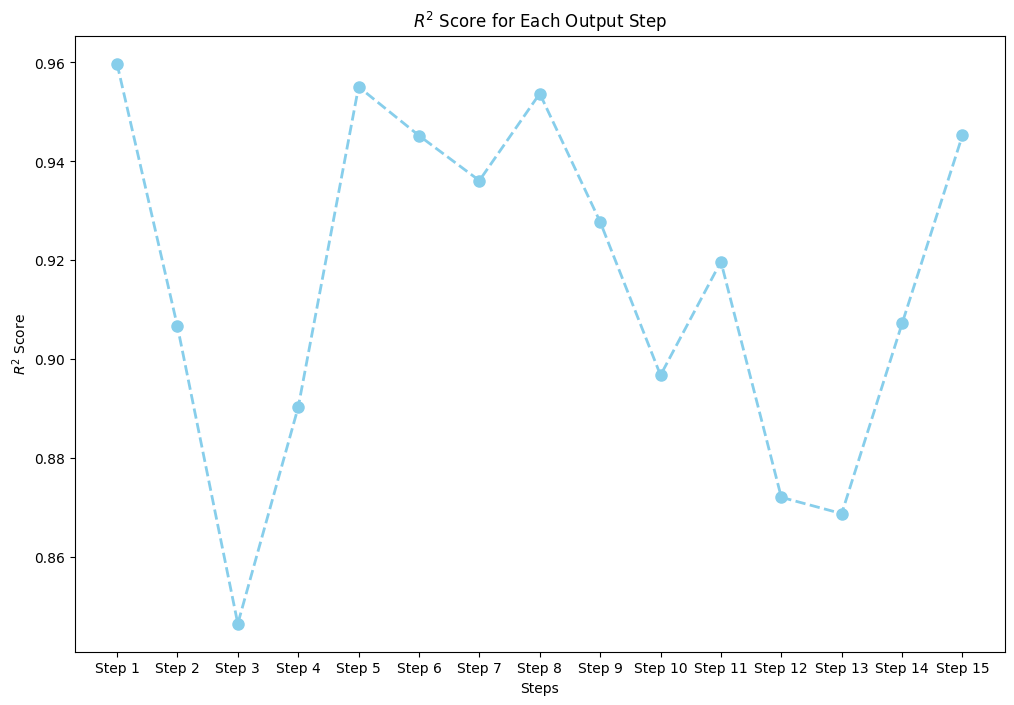

In [23]:
r2_scores = [r2_score(y_test[:, i], y_pred[:, i]) for i in range(pred_horizon)]

plt.figure(figsize=(12, 8))
plt.plot(range(1, pred_horizon+1), r2_scores, color='skyblue', marker='o', linestyle='dashed', linewidth=2, markersize=8)
plt.xlabel('Steps')
plt.ylabel('$R^2$ Score')
plt.title('$R^2$ Score for Each Output Step')
plt.xticks(range(1, pred_horizon+1), labels=[f'Step {i}' for i in range(1, pred_horizon+1)])
plt.show()

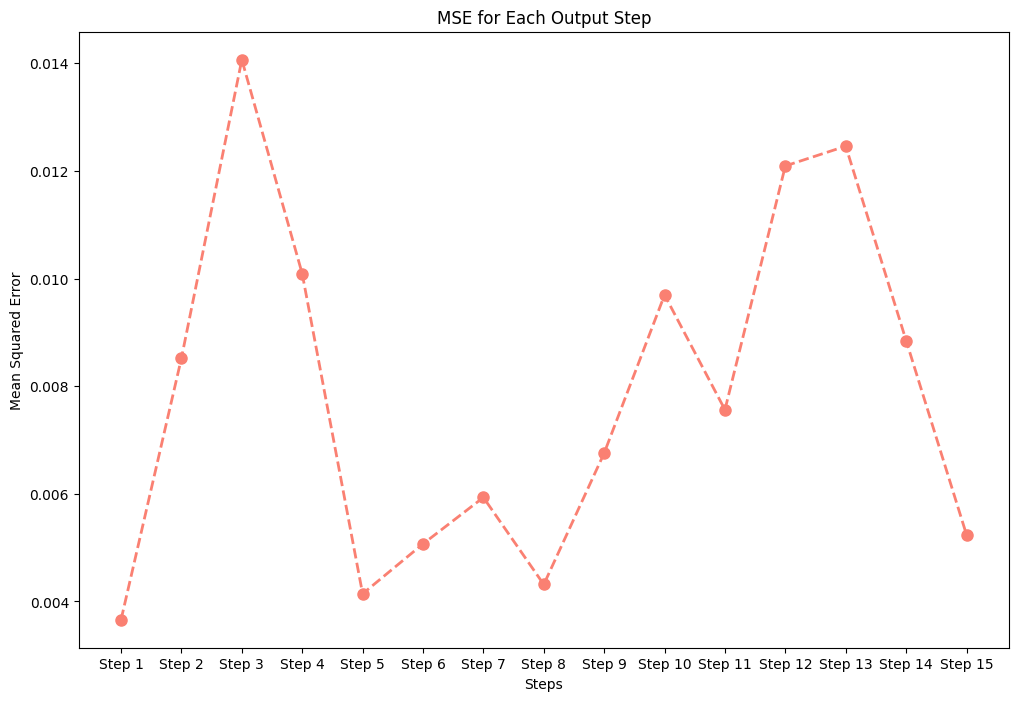

In [24]:
mse_per_step = [mean_squared_error(y_test[:, i], y_pred[:, i]) for i in range(pred_horizon)]

plt.figure(figsize=(12, 8))
plt.plot(range(1, pred_horizon + 1), mse_per_step, color='salmon', marker='o', linestyle='dashed', linewidth=2, markersize=8)
plt.xlabel('Steps')
plt.ylabel('Mean Squared Error')
plt.title('MSE for Each Output Step')
plt.xticks(range(1, pred_horizon + 1), labels=[f'Step {i}' for i in range(1, pred_horizon + 1)])
plt.show()

R² Score for Horizon 1: 0.9597
R² Score for Horizon 2: 0.9066
R² Score for Horizon 3: 0.8465
R² Score for Horizon 4: 0.8903
R² Score for Horizon 5: 0.9551
R² Score for Horizon 6: 0.9452
R² Score for Horizon 7: 0.9361
R² Score for Horizon 8: 0.9537
R² Score for Horizon 9: 0.9278
R² Score for Horizon 10: 0.8967
R² Score for Horizon 11: 0.9197
R² Score for Horizon 12: 0.8720
R² Score for Horizon 13: 0.8687
R² Score for Horizon 14: 0.9072
R² Score for Horizon 15: 0.9453
MSE for Horizon 1: 0.0037
MSE for Horizon 2: 0.0085
MSE for Horizon 3: 0.0141
MSE for Horizon 4: 0.0101
MSE for Horizon 5: 0.0041
MSE for Horizon 6: 0.0051
MSE for Horizon 7: 0.0059
MSE for Horizon 8: 0.0043
MSE for Horizon 9: 0.0068
MSE for Horizon 10: 0.0097
MSE for Horizon 11: 0.0076
MSE for Horizon 12: 0.0121
MSE for Horizon 13: 0.0125
MSE for Horizon 14: 0.0088
MSE for Horizon 15: 0.0052


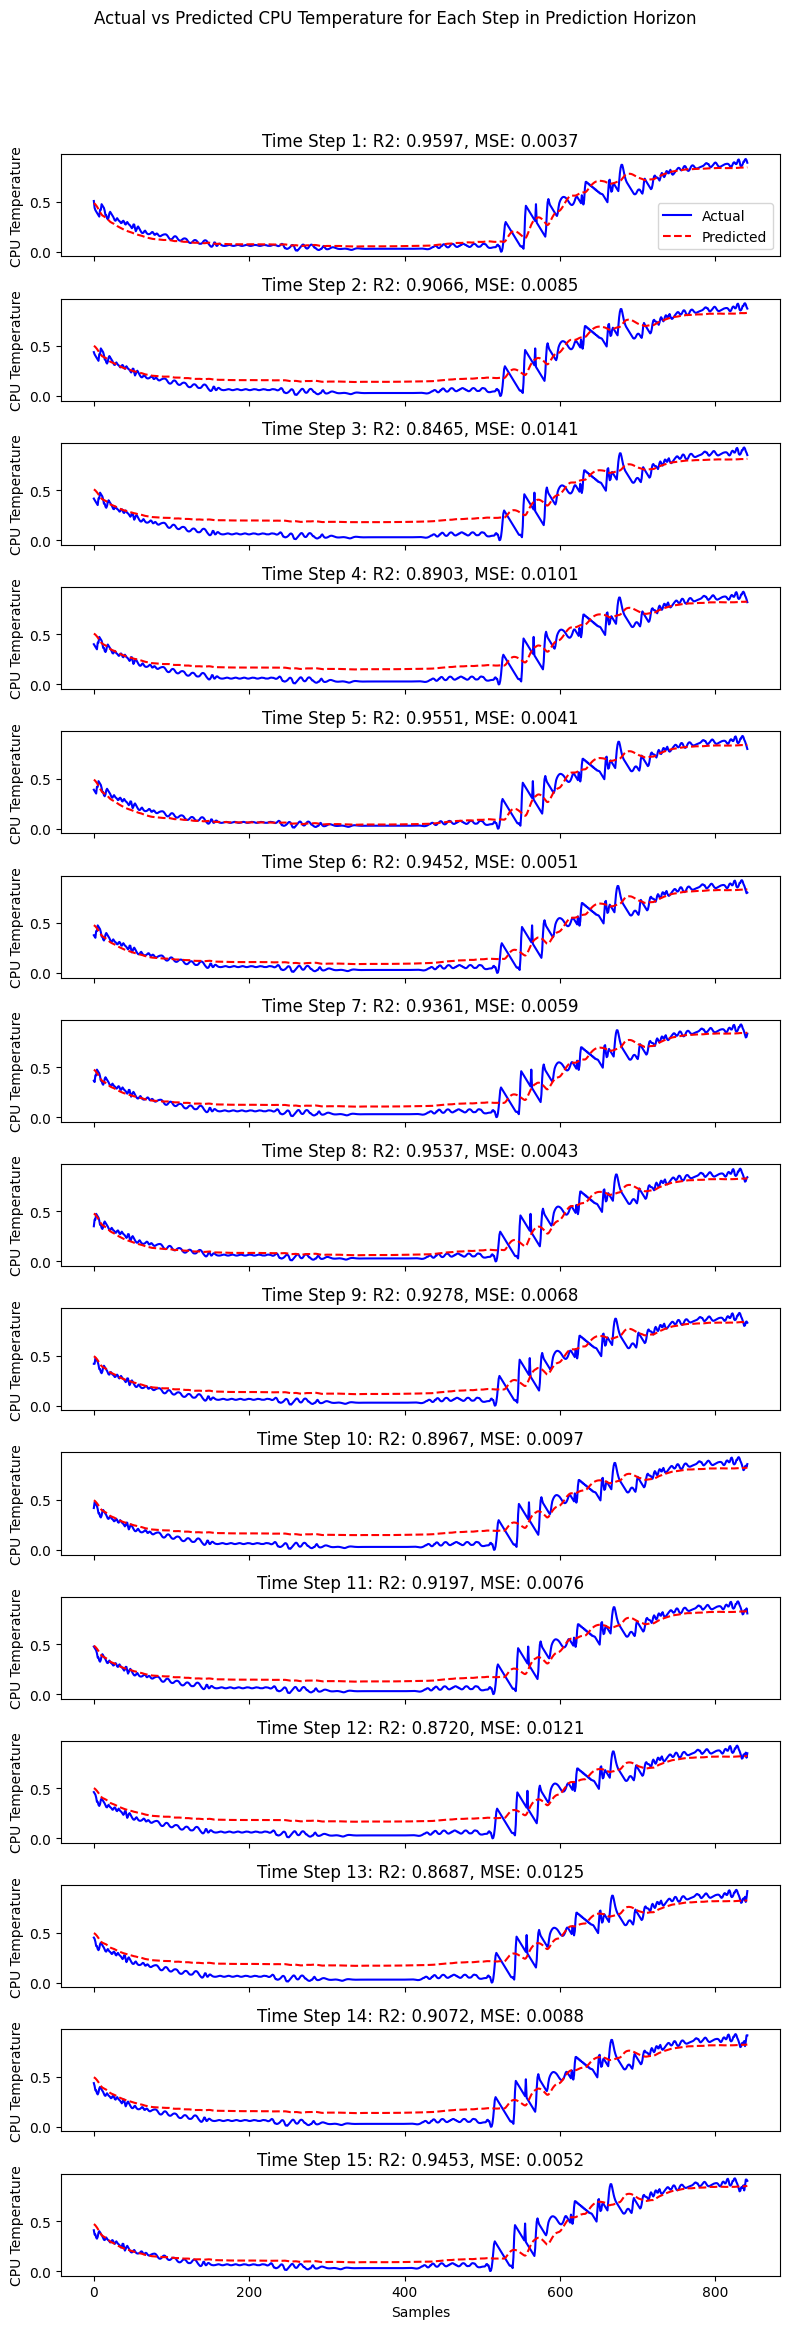

In [25]:
mse_scores = mse_per_step
r2_scores = r2_scores

for step in range(y_pred.shape[1]):
    r2 = r2_score(y_test[:, step], y_pred[:, step])
    r2_scores.append(r2)
    print(f"R² Score for Horizon {step + 1}: {r2:.4f}")

for step in range(y_pred.shape[1]):
    mse = mean_squared_error(y_test[:, step], y_pred[:, step])
    mse_scores.append(mse)
    print(f"MSE for Horizon {step + 1}: {mse:.4f}")

output_horizon = y_pred.shape[1]
fig, axes = plt.subplots(output_horizon, 1, figsize=(8, 25), sharex=True)

for step in range(output_horizon):
    axes[step].plot(y_test[:, step], label='Actual', color='blue')
    axes[step].plot(y_pred[:, step], label='Predicted', color='red', linestyle='dashed')
    axes[step].set_title(f'Time Step {step + 1}: R2: {r2_scores[step]:.4f}, MSE: {mse_scores[step]:.4f}')
    axes[step].set_ylabel("CPU Temperature")
    if step == 0:
        axes[step].legend()

plt.xlabel("Samples")
plt.suptitle("Actual vs Predicted CPU Temperature for Each Step in Prediction Horizon")
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

## Seq2Seq model

In [34]:
df_scaled.head()

,cpu_temp,inlet_temp,it_power,fan_speed
0,0.671717,0.065816,0.671238,0.077869
1,0.666286,0.065810,0.671315,0.077907
2,0.660725,0.065806,0.671492,0.077959
3,0.653554,0.065802,0.671769,0.078024
4,0.644006,0.065802,0.671769,0.078024


In [35]:
data = df_scaled.to_numpy()
data = torch.tensor(data, dtype=torch.float32)

In [36]:
def create_sequences(data, input_window, output_horizon):
    inputs, targets = [], []
    for i in range(len(data) - input_window - output_horizon + 1):
        inputs.append(data[i:i + input_window])  
        targets.append(data[i + input_window:i + input_window + output_horizon, 0])  
    return torch.stack(inputs), torch.stack(targets)

In [37]:
from torch.utils.data import DataLoader, TensorDataset

In [43]:
input_window = 30
output_horizon = 15
batch_size = 32
n_features = 4  
output_dim = 1  
epochs = 25
learning_rate = 0.001

inputs, targets = create_sequences(data, input_window, output_horizon)
dataset = TensorDataset(inputs, targets.unsqueeze(-1))  

train_ratio = 0.8  
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset = TensorDataset(inputs[:train_size], targets[:train_size].unsqueeze(-1))
test_dataset = TensorDataset(inputs[train_size:], targets[train_size:].unsqueeze(-1))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [44]:
class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(Seq2SeqLSTM, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder = nn.LSTM(output_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size = x.size(0)
        _, (hidden, cell) = self.encoder(x)
        decoder_input = x[:, -1, 0].unsqueeze(1).unsqueeze(2) 
        outputs = []

        for _ in range(output_horizon):
            out, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            pred = self.fc(out)
            outputs.append(pred)
            decoder_input = pred  

        return torch.cat(outputs, dim=1)

In [45]:
model = Seq2SeqLSTM(input_dim=n_features, hidden_dim=64, output_dim=output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [46]:
losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")
    losses.append(train_loss/len(train_loader))

Epoch 1/25, Loss: 0.0800
Epoch 2/25, Loss: 0.0048
Epoch 3/25, Loss: 0.0034
Epoch 4/25, Loss: 0.0036
Epoch 5/25, Loss: 0.0033
Epoch 6/25, Loss: 0.0032
Epoch 7/25, Loss: 0.0031
Epoch 8/25, Loss: 0.0030
Epoch 9/25, Loss: 0.0032
Epoch 10/25, Loss: 0.0033
Epoch 11/25, Loss: 0.0031
Epoch 12/25, Loss: 0.0031
Epoch 13/25, Loss: 0.0028
Epoch 14/25, Loss: 0.0029
Epoch 15/25, Loss: 0.0029
Epoch 16/25, Loss: 0.0028
Epoch 17/25, Loss: 0.0029
Epoch 18/25, Loss: 0.0028
Epoch 19/25, Loss: 0.0028
Epoch 20/25, Loss: 0.0029
Epoch 21/25, Loss: 0.0028
Epoch 22/25, Loss: 0.0027
Epoch 23/25, Loss: 0.0029
Epoch 24/25, Loss: 0.0028
Epoch 25/25, Loss: 0.0027


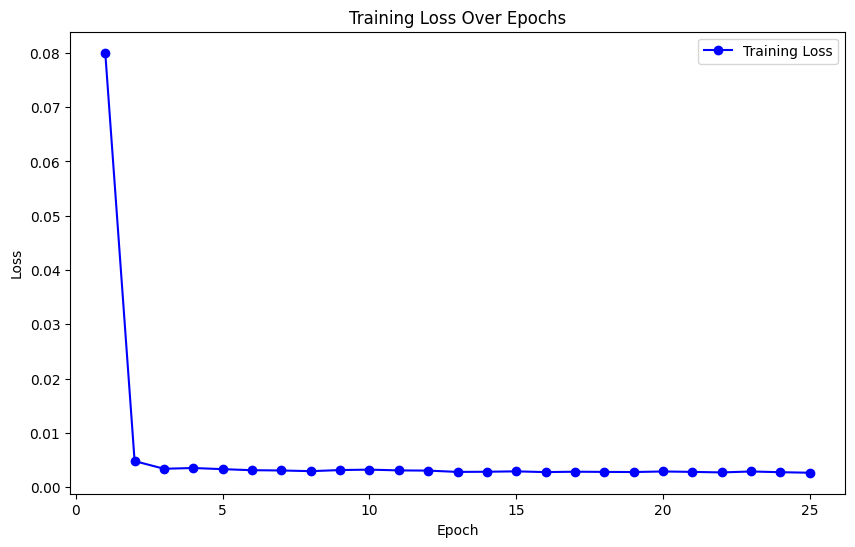

In [59]:
epochs = len(losses)

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, marker='o', linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

In [65]:
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            output = model(x_batch)
            loss = criterion(output, y_batch)
            total_loss += loss.item()

            all_outputs.append(output.numpy())
            all_targets.append(y_batch.numpy())

    avg_loss = total_loss / len(dataloader)
    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    all_outputs = np.column_stack([scalers['cpu_temp'].inverse_transform(all_outputs[:, i].reshape(-1, 1)).ravel() for i in range(all_outputs.shape[1])])
    all_targets = np.column_stack([scalers["cpu_temp"].inverse_transform(all_targets[:, i].reshape(-1, 1)).ravel() for i in range(all_targets.shape[1])])

    all_outputs = all_outputs.reshape(all_outputs.shape[0], -1)
    all_targets = all_targets.reshape(all_targets.shape[0], -1)

    print(f"Evaluation Loss (MSE): {avg_loss:.4f}")
    mse_scores = []
    r2_scores = []

    for step in range(all_outputs.shape[1]):
        r2 = r2_score(all_targets[:, step], all_outputs[:, step])
        r2_scores.append(r2)
        print(f"R² Score for Horizon {step + 1}: {r2:.4f}")

    for step in range(all_outputs.shape[1]):
        mse = mean_squared_error(all_targets[:, step], all_outputs[:, step])
        mse_scores.append(mse)
        print(f"MSE for Horizon {step + 1}: {mse:.4f}")

    output_horizon = all_outputs.shape[1]
    fig, axes = plt.subplots(output_horizon, 1, figsize=(8, 25), sharex=True)
    
    for step in range(output_horizon):
        axes[step].plot(all_targets[:, step], label='Actual', color='blue')
        axes[step].plot(all_outputs[:, step], label='Predicted', color='red', linestyle='dashed')
        axes[step].set_title(f'Time Step {step + 1}: R2: {r2_scores[step]:.4f}, MSE: {mse_scores[step]:.4f}')
        axes[step].set_ylabel("CPU Temperature")
        if step == 0:
            axes[step].legend()

    plt.xlabel("Samples")
    plt.suptitle("Actual vs Predicted CPU Temperature for Each Step in Prediction Horizon")
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

    return r2_scores, mse_scores

Evaluation Loss (MSE): 0.0070
R² Score for Horizon 1: 0.9429
R² Score for Horizon 2: 0.9406
R² Score for Horizon 3: 0.9378
R² Score for Horizon 4: 0.9349
R² Score for Horizon 5: 0.9317
R² Score for Horizon 6: 0.9285
R² Score for Horizon 7: 0.9255
R² Score for Horizon 8: 0.9227
R² Score for Horizon 9: 0.9204
R² Score for Horizon 10: 0.9181
R² Score for Horizon 11: 0.9162
R² Score for Horizon 12: 0.9145
R² Score for Horizon 13: 0.9131
R² Score for Horizon 14: 0.9118
R² Score for Horizon 15: 0.9106
MSE for Horizon 1: 4.4130
MSE for Horizon 2: 4.6038
MSE for Horizon 3: 4.8350
MSE for Horizon 4: 5.0805
MSE for Horizon 5: 5.3455
MSE for Horizon 6: 5.6141
MSE for Horizon 7: 5.8730
MSE for Horizon 8: 6.1111
MSE for Horizon 9: 6.3190
MSE for Horizon 10: 6.5265
MSE for Horizon 11: 6.7037
MSE for Horizon 12: 6.8643
MSE for Horizon 13: 7.0070
MSE for Horizon 14: 7.1413
MSE for Horizon 15: 7.2707


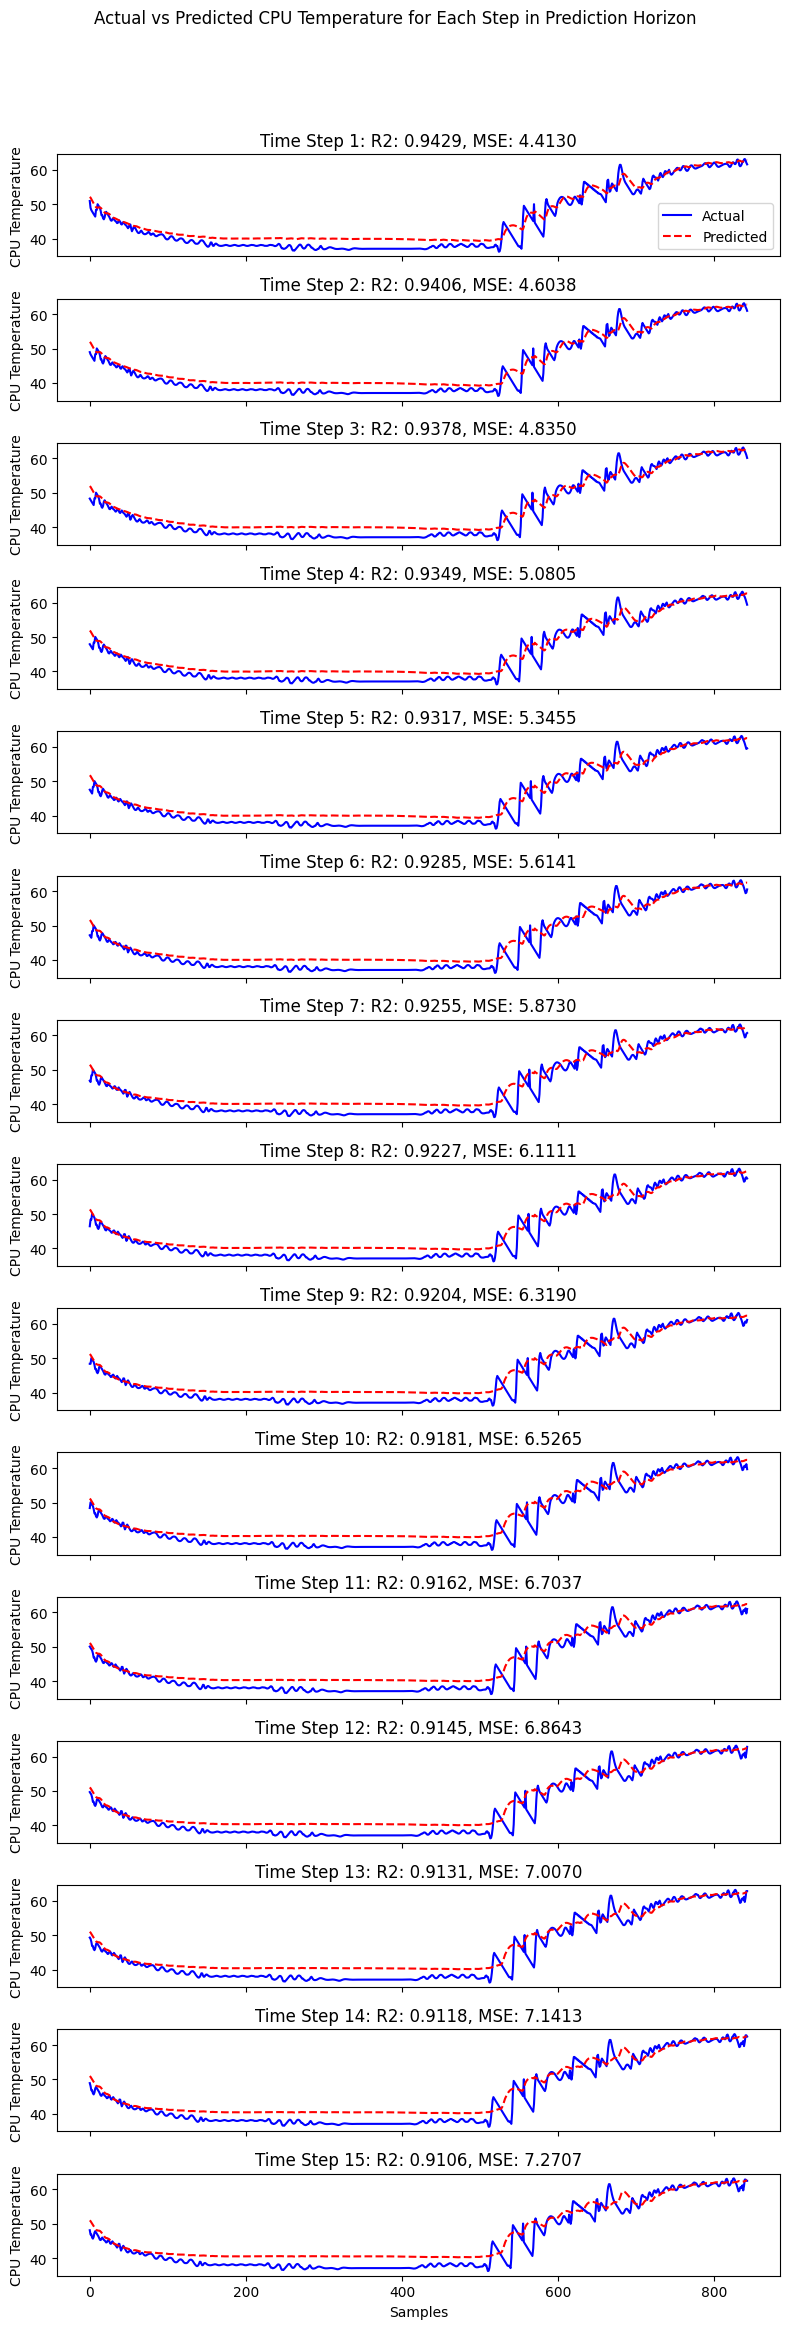

In [66]:
r2_scores, mse_scores = evaluate_model(model, test_loader)

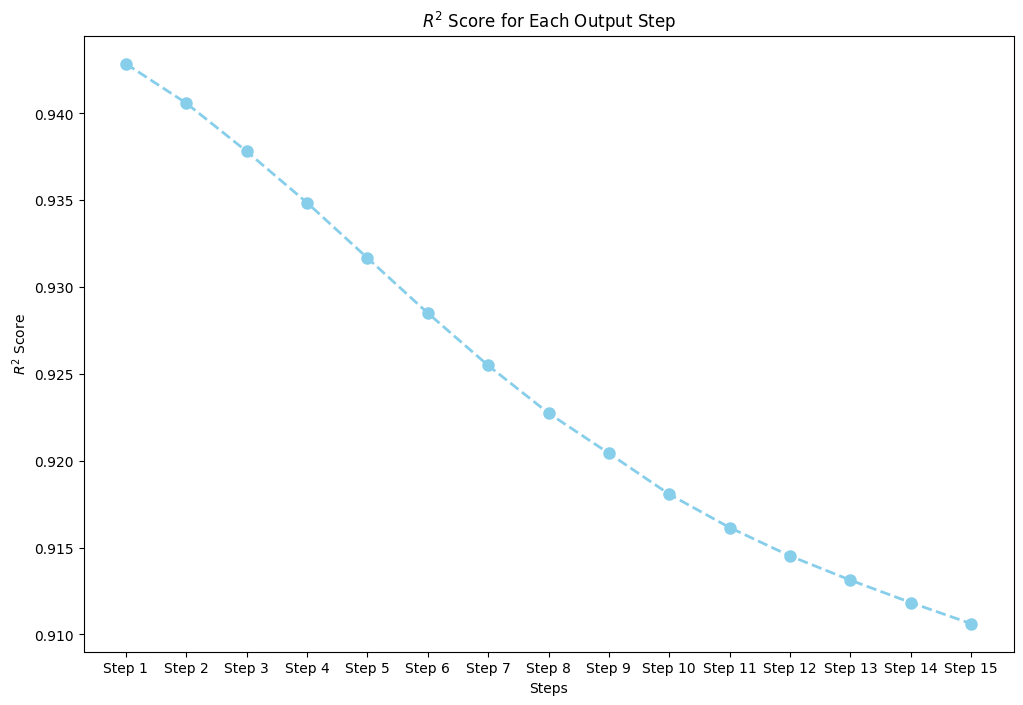

In [67]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, output_horizon+1), r2_scores, color='skyblue', marker='o', linestyle='dashed', linewidth=2, markersize=8)
plt.xlabel('Steps')
plt.ylabel('$R^2$ Score')
plt.title('$R^2$ Score for Each Output Step')
plt.xticks(range(1, output_horizon+1), labels=[f'Step {i}' for i in range(1, output_horizon+1)])
plt.show()

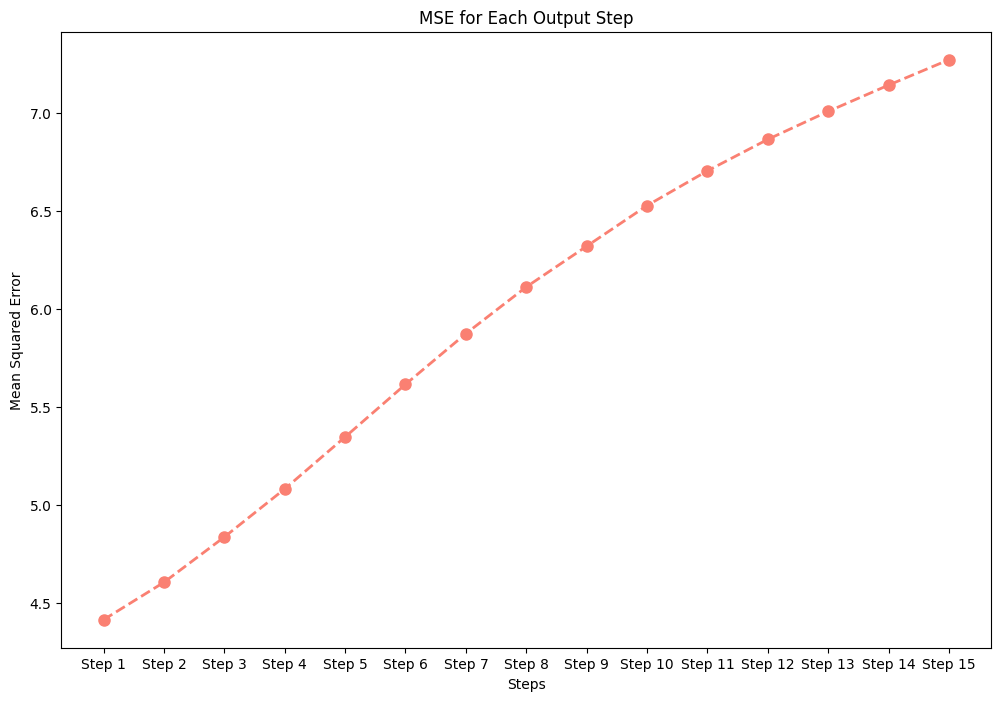

In [68]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, output_horizon + 1), mse_scores, color='salmon', marker='o', linestyle='dashed', linewidth=2, markersize=8)
plt.xlabel('Steps')
plt.ylabel('Mean Squared Error')
plt.title('MSE for Each Output Step')
plt.xticks(range(1, output_horizon + 1), labels=[f'Step {i}' for i in range(1, output_horizon + 1)])
plt.show()